Adapted from [PyTorch Tutorial](https://pytorch.org/tutorials/beginner/blitz/cifar10_tutorial.html)

In [1]:
# Bunch of useful libraries + wngrad
from collections import defaultdict
import numpy as np
import numpy.matlib
import scipy
import scipy.sparse as sps
import math
import matplotlib.pyplot as plt
import time
import torch
from sklearn.datasets import load_svmlight_file
import random
import helpers
from wngrad import WNGrad
import torchvision
import copy
%matplotlib inline

In [2]:
# import tensorflow.keras.datasets.mnist as mnist
# (train_input, train_target), (test_input, test_target) = mnist.load_data()

# train_input = torch.from_numpy(train_input.astype('float64'))
# train_input = train_input.data.view(-1, 1, 28, 28).float()
# train_target = torch.from_numpy(train_target.astype('float64'))
# test_input = torch.from_numpy(test_input.astype('float64'))
# test_input = test_input.data.view(-1, 1, 28, 28).float()
# test_target = torch.from_numpy(test_target.astype('float64'))

# batch_size = 10

# trainloader = torch.utils.data.DataLoader(trainset, batch_size=batch_size,
#                                           shuffle=True, num_workers=2)
# testloader = torch.utils.data.DataLoader(testset, batch_size=batch_size,
#                                          shuffle=False, num_workers=2)

In [3]:
transform = torchvision.transforms.Compose(
    [torchvision.transforms.ToTensor(),
     torchvision.transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))])

batch_size = 10

trainset = torchvision.datasets.CIFAR10(root='./data', train=True,
                                        download=True, transform=transform)
trainloader = torch.utils.data.DataLoader(trainset, batch_size=batch_size,
                                          shuffle=True, num_workers=2)
trainloader_1batch = torch.utils.data.DataLoader(trainset, batch_size=50000,
                                          shuffle=True, num_workers=1)

testset = torchvision.datasets.CIFAR10(root='./data', train=False,
                                       download=True, transform=transform)
testloader = torch.utils.data.DataLoader(testset, batch_size=batch_size,
                                         shuffle=False, num_workers=2)

classes = ('plane', 'car', 'bird', 'cat',
           'deer', 'dog', 'frog', 'horse', 'ship', 'truck')

Files already downloaded and verified
Files already downloaded and verified


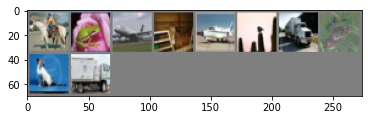

horse  frog plane horse plane  bird truck  frog   cat truck


In [4]:
import matplotlib.pyplot as plt
import numpy as np

# functions to show an image


def imshow(img):
    img = img / 2 + 0.5     # unnormalize
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    plt.show()


# get some random training images
dataiter = iter(trainloader)
images, labels = dataiter.next()

# show images
imshow(torchvision.utils.make_grid(images))
# print labels
print(' '.join('%5s' % classes[labels[j]] for j in range(batch_size)))

In [5]:
import torch.nn as nn
import torch.nn.functional as F

class Net(nn.Module):
    def __init__(self):
        super().__init__()
        self.conv1 = nn.Conv2d(3, 6, 5)
        self.pool = nn.MaxPool2d(2, 2)
        self.conv2 = nn.Conv2d(6, 16, 5)
        self.fc1 = nn.Linear(16 * 5 * 5, 120)
        self.fc2 = nn.Linear(120, 84)
        self.fc3 = nn.Linear(84, 10)

    def forward(self, x):
        x = self.pool(F.relu(self.conv1(x)))
        x = self.pool(F.relu(self.conv2(x)))
        x = torch.flatten(x, 1) # flatten all dimensions except batch
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = self.fc3(x)
        return x

In [6]:
def train_SGD(optimizer, net, epochs):
    history = defaultdict(list)
    for epoch in range(epochs):  # loop over the dataset multiple times

        running_loss = 0.0
        for i, data in enumerate(trainloader, 0):
            net.train()
            # get the inputs; data is a list of [inputs, labels]
            inputs, labels = data

            # zero the parameter gradients
            optimizer.zero_grad()

            # forward + backward + optimize
            outputs = net(inputs)
            loss = criterion(outputs, labels)
            loss.backward()
            if 'SGD' in str(optimizer):
                optimizer.step()
            elif 'WNGrad' in str(optimizer):
                
                # Store original parameters, and flatten params and grad
                if epoch == 0 and i == 0:
                    b_candidates = []
                    orig_param_list = []
                    grad_flat = torch.empty((0,))
                    param_flat = torch.empty((0,))
                    layers = []
                    for name, param in net.named_parameters():
                        orig_param_list.append(param)
                        grad_flat = torch.cat((grad_flat, param.grad.flatten()))
                        param_flat = torch.cat((param_flat, param.flatten()))
                        layers.append(name.split('.')[0])

                    for i in np.arange(-5, 0, 0.1):
                        for i_layer, layer in enumerate(layers):
                            if i_layer % 2 == 0: # Weight
                                getattr(net, layers[i_layer].split('.')[0]).weight = torch.nn.Parameter(
                                    orig_param_list[i_layer] + torch.empty_like(orig_param_list[i_layer]).normal_(0, 10**i))
                            else:
                                getattr(net, layers[i_layer].split('.')[0]).bias = torch.nn.Parameter(
                                    orig_param_list[i_layer] + torch.empty_like(orig_param_list[i_layer]).normal_(0, 10**i))



                        # Get gradient
                        outputs = net(inputs)
                        loss = criterion(outputs, labels)
#                         print(getattr(net, layers[i_layer].split('.')[0]).bias.grad)
                        loss.backward()

                        # Retreive gradient
                        grad_flat_temp = torch.empty((0,))
                        param_flat_temp = torch.empty((0,))
                        for name, param in net.named_parameters():
                            grad_flat_temp = torch.cat((grad_flat_temp, param.grad.flatten()))
                            param_flat_temp = torch.cat((param_flat_temp, param.flatten()))
                        
#                         print(grad_flat_temp.mean(), grad_flat.mean(), param_flat_temp.mean(), param_flat.mean(),)
                        b_candidates.append((grad_flat_temp - grad_flat).norm(2)/(param_flat_temp - param_flat).norm(2))

                        # Once initialization search is over...
                    
                    # Put originals back in place
                    for i_layer, layer in enumerate(layers):
                        if i_layer % 2 == 0: # Weight
                            getattr(net, layers[i_layer].split('.')[0]).weight = orig_param_list[i_layer]
                        else:
                            getattr(net, layers[i_layer].split('.')[0]).bias = orig_param_list[i_layer]
                    
                    # And choose a b
#                     print(b_candidates)
                    b = max(b_candidates)
#                     b = 50
                    print('Initial_b: ', b, 'Max candidates: ', sorted(b_candidates)[-2])
                    optimizer.b = b
#                     raise Exception()
                elif i % 500 == 499:
                    print('Current b:', optimizer.b)
                def closure():
                    optimizer.zero_grad()
                    outputs = net(inputs)
                    loss = criterion(outputs, labels)
                    return loss
                optimizer.step(closure)

            # print statistics
            running_loss += loss.item()
#             if i % 10 == 9:    # Store every 10 mini-batches
#                 history["iter"].append(i*(epoch+1))
#                 history["loss"].append(running_loss)
# #                 print(f'loss = {running_loss}')
# #                 print('[%d, %5d] loss: %.3f' %
# #                       (epoch + 1, i + 1, running_loss / 2000))
#                 running_loss = 0.0
            if i % 500 == 499:    # print every 2000 mini-batches
                net.eval()
                print('[%d, %5d] loss: %.3f' %
                      (epoch + 1, i + 1, running_loss / 5000))
                history["iter"].append(i+len(trainloader)*epoch+1)
                history["train loss"].append(running_loss)
                running_loss = 0.0
                total = 0
                correct = 0
                with torch.no_grad():
                    test_loss = 0
                    for data in testloader:
                        images, labels = data
                        # calculate outputs by running images through the network
                        outputs = net(images)
                        test_loss += criterion(outputs, labels)
                        
                        # the class with the highest energy is what we choose as prediction
                        _, predicted = torch.max(outputs.data, 1)
                        total += labels.size(0)
                        correct += (predicted == labels).sum().item()
                history["test accuracy"].append(100*correct/total)
                print(100*correct/total, '%')
                history["test loss"].append(test_loss)
#                 print('Accuracy of the network on the 10000 test images: %d %%' % (
#                     100 * correct / total))
    return history

In [7]:
criterion = torch.nn.CrossEntropyLoss()
net_SGD = Net()
optimizer_SGD = torch.optim.SGD(net_SGD.parameters(), lr=0.001, momentum=0.9)
history = train_SGD(optimizer_SGD, net_SGD, 2)
net_WNGrad = Net()
optimizer_WNGrad = WNGrad(net_WNGrad.parameters())
history_WNGrad = train_SGD(optimizer_WNGrad, net_WNGrad, 2)

[1,   500] loss: 0.230
17.48 %
[1,  1000] loss: 0.225
21.26 %
[1,  1500] loss: 0.207
29.03 %
[1,  2000] loss: 0.190
32.19 %
[1,  2500] loss: 0.182
34.51 %
[1,  3000] loss: 0.171
39.18 %
[1,  3500] loss: 0.167
39.91 %
[1,  4000] loss: 0.163
41.51 %
[1,  4500] loss: 0.160
41.55 %
[1,  5000] loss: 0.158
44.16 %
[2,   500] loss: 0.150
43.13 %
[2,  1000] loss: 0.151
45.51 %
[2,  1500] loss: 0.148
46.41 %
[2,  2000] loss: 0.148
47.55 %
[2,  2500] loss: 0.146
48.64 %
[2,  3000] loss: 0.143
48.29 %
[2,  3500] loss: 0.139
49.78 %
[2,  4000] loss: 0.140
48.9 %
[2,  4500] loss: 0.141
48.28 %
[2,  5000] loss: 0.137
50.76 %
Initial_b:  tensor(63.4023, grad_fn=<DivBackward0>) Max candidates:  tensor(57.0173, grad_fn=<DivBackward0>)
Current b: tensor(66.2203)
[1,   500] loss: 1.853
11.35 %
Current b: tensor(69.7587)
[1,  1000] loss: 0.229
12.3 %
Current b: tensor(81.0207)
[1,  1500] loss: 0.211
25.39 %
Current b: tensor(97.3499)
[1,  2000] loss: 0.193
29.47 %
Current b: tensor(112.6682)
[1,  2500] lo

## Test

In [8]:
dataiter = iter(testloader)
images, labels = dataiter.next()
print('GroundTruth: ', ' '.join('%5s' % classes[labels[j]] for j in range(4)))
outputs = net_WNGrad(images)
_, predicted = torch.max(outputs, 1)
print('Predicted: ', ' '.join('%5s' % classes[predicted[j]]
                              for j in range(4)))

GroundTruth:    cat  ship  ship plane
Predicted:    cat   car   car  ship


In [9]:
correct = 0
total = 0
# since we're not training, we don't need to calculate the gradients for our outputs
with torch.no_grad():
    for data in testloader:
        images, labels = data
        # calculate outputs by running images through the network
        outputs = net_WNGrad(images)
        # the class with the highest energy is what we choose as prediction
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()
acc = 100 * correct / total
print(f'Accuracy of the network trained with WNGrad on the 10000 test images: {acc}')

correct = 0
total = 0
# since we're not training, we don't need to calculate the gradients for our outputs
with torch.no_grad():
    for data in testloader:
        images, labels = data
        # calculate outputs by running images through the network
        outputs = net_SGD(images)
        # the class with the highest energy is what we choose as prediction
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()
acc = 100 * correct / total
print(f'Accuracy of the network trained with SGD on the 10000 test images: {acc}')

Accuracy of the network trained with WNGrad on the 10000 test images: 47.0
Accuracy of the network trained with SGD on the 10000 test images: 50.76


Text(0.5, 1.0, 'SGD vs WNGrad in a NeuralNet')

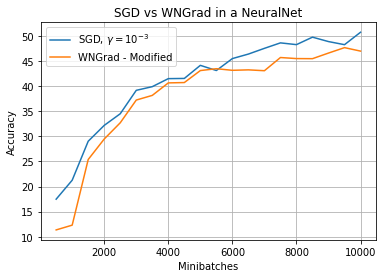

In [14]:
plt.figure()
ax = plt.gca(); ax.grid()
plt.plot(history["iter"], history["test accuracy"], label="SGD, $\gamma = 10^{-3}$")
plt.plot(history_WNGrad["iter"], history_WNGrad["test accuracy"], label="WNGrad - Modified")
plt.legend(); plt.xlabel('Minibatches'); plt.ylabel('Accuracy'); plt.title('SGD vs WNGrad in a NeuralNet')